In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
#from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 
import cmocean

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [2]:
#import dataset
df = pd.read_csv('./final_data/df_pm_o3_county_nuclear_geo_avg.csv', index_col = 0)

In [3]:
df['County_State'] = df['County_State'].str.lower()

Mortality data from: https://wonder.cdc.gov/controller/datarequest/D140;jsessionid=3706D5550499EA883D9361BB7FC6
Centers for Disease Control and Prevention, National Center for Health Statistics. Compressed Mortality File 1999-2016 on CDC WONDER Online Database, released June 2017. Data are from the Compressed Mortality File 1999-2016 Series 20 No. 2U, 2016, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/cmf-icd10.html on Jul 13, 2021 2:41:50 PM

In [4]:
mort_df = pd.read_excel('data/compressed_mortality_cdc.xlsx')
mort_df = mort_df.drop(columns = 'Notes')
mort_df.dropna(inplace = True)

In [5]:
mort_df2 = pd.read_excel('./data/compressed_mortality_cdc_hispanic.xlsx')
mort_df2 = mort_df2.drop(columns = {'Notes'})
mort_df2.dropna(inplace = True)

In [6]:
mort_df.rename(columns = {'Race':'Race/Hispanic Origin'}, inplace = True)
mort_df2.rename(columns = {'Hispanic Origin':'Race/Hispanic Origin'}, inplace = True)

In [7]:
mort_df = pd.concat([mort_df, mort_df2])
mort_df.loc[mort_df['Population'] == 'Not Applicable','Population'] = np.nan

In [8]:
mort_df['County'] = mort_df['County'].astype('string')
mort_df[['county','state']] = mort_df['County'].str.split(', ',expand=True)

In [9]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [10]:
mort_df['state'] = mort_df['state'].map(lambda x: x.replace(" ", ""))
state_list = [states[i] for i in mort_df['state'].values]
mort_df['state'] = state_list

In [11]:
mort_df['county'] = mort_df['county'].str.replace(' Parish', '')
mort_df['county'] = mort_df['county'].str.replace(' County', '')
mort_df['county'] = mort_df['county'].str.replace(' city', '')
mort_df.loc[(mort_df['county'] == 'Shannon') & (mort_df['state'] == 'South Dakota'), 'county'] = 'Oglala Lakota'

In [12]:
mort_df['county'] = mort_df['county'].str.lower()
mort_df['state'] = mort_df['state'].str.lower()

In [13]:
mort_df['County_State'] = mort_df['county'] + ', ' + mort_df['state']

In [14]:
poll_df = df[df.StateName.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]

In [15]:
mort_df = mort_df[mort_df.state.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]


In [16]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


mc kean, pennsylvania []
la porte, indiana []
debaca, new mexico []
de kalb, indiana []
dona ana, new mexico []


In [17]:
poll_df.loc[poll_df['County_State'] == 'laporte, indiana', 'County_State'] = 'la porte, indiana'
poll_df.loc[poll_df['County_State'] == 'mckean, pennsylvania', 'County_State'] = 'mc kean, pennsylvania'
poll_df.loc[poll_df['County_State'] == 'doña ana, new mexico', 'County_State'] = 'dona ana, new mexico'
poll_df.loc[poll_df['County_State'] == 'dekalb, indiana', 'County_State'] = 'de kalb, indiana'
poll_df.loc[poll_df['County_State'] == 'de baca, new mexico', 'County_State'] = 'debaca, new mexico'

In [18]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


In [19]:
combined_df = mort_df.merge(poll_df, on = 'County_State')

In [20]:
combined_df['Population'] = combined_df['Population'].fillna(-9999)

In [21]:
combined_df['geometry'] = geopandas.GeoSeries.from_wkt(combined_df['geometry_county'])
geo_df = geopandas.GeoDataFrame(combined_df, geometry='geometry')

In [22]:
combined_df = geo_df.copy()

In [23]:
combined_df['O3']*=1e9

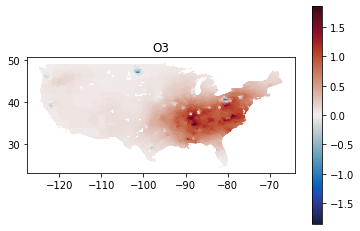

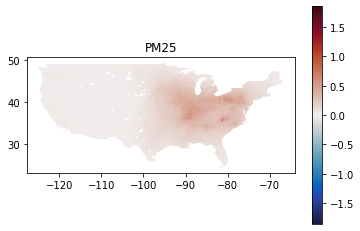

In [24]:
for p in ['O3','PM25']:
    combined_df.plot(column = p, legend=True, 
                                         vmin = -1.85, vmax = 1.85, 
                                         cmap = cmocean.cm.balance)
    plt.title( p)


## Beta calculations for PM

In [25]:
np.unique(combined_df['Race/Hispanic Origin'] )

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Not Stated', 'White'], dtype=object)

In [42]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_mean'] = 1.208
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_mean'] = 1.063
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_mean'] = 1.096
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_mean'] = 1.116
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_mean'] = 1.100

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_low'] = 1.199
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_low'] = 1.060
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_low'] = 1.075
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_low'] = 1.100
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_low'] = 1.060

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_high'] = 1.217
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_high'] = 1.065
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_high'] = 1.117
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_high'] = 1.133
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_high'] = 1.140

In [43]:
delta_chi = 10 #ug/m3
for sub in ['_mean', '_low', '_high']:
    combined_df[f'β_PM{sub}'] = np.log(combined_df[f'RR_PM{sub}'])/delta_chi
    combined_df['mortality_0'] = combined_df['Deaths']/combined_df['Population']
    combined_df[f'Δmortality_PM{sub}'] =  combined_df['PM25']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_PM{sub}']



# Calculations for Ozone

RR from Di et al. 
ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [44]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_mean'] = 1.009
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_mean'] = 1.013
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_mean'] = .980
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_mean'] = .975
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_mean'] = .961

In [45]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_low'] = 1.005
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_low'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_low'] = .972
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_low'] = .968
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_low'] = .944

In [46]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_high'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_high'] = 1.014
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_high'] = .988
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_high'] = .981
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_high'] = .978

In [47]:
delta_chi = 10 #ppb
for sub in ['_mean', '_low', '_high']:
    combined_df[f'β_O3{sub}'] = np.log(combined_df[f'RR_O3{sub}'])/delta_chi
    combined_df[f'Δmortality_O3{sub}'] =  combined_df['O3']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_O3{sub}']



## Additional Calculations

In [48]:
geometry_df = combined_df.groupby(
    ['County_State','Race/Hispanic Origin','nuclear_adjacent']).first()

In [49]:
combined_df['O3_mortalities/population'] = combined_df['Δmortality_O3_mean']/combined_df['Population']*1e5
combined_df['PM_mortalities/population'] = combined_df['Δmortality_PM_mean']/combined_df['Population']*1e5

In [50]:
final_df = combined_df.groupby(['County_State','Race/Hispanic Origin','nuclear_adjacent']).mean()

In [51]:
final_df = final_df.join(geometry_df['geometry'])

## Percent of population exposed

In [52]:
percent_dict = {}
for re in ['White', 'American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino'
        ]:
    percent_dict[re + ' pop'] = pd.DataFrame(combined_df[combined_df['Race/Hispanic Origin'] == re].set_index('County_State')['Population']/combined_df.groupby('County_State').sum()['Population']).rename(columns = {'Population': re + ' pop'})
    percent_dict[re + ' O3'] = pd.DataFrame(combined_df[combined_df['Race/Hispanic Origin'] == re].set_index('County_State')['Δmortality_O3_mean']/combined_df.groupby('County_State').sum()['Δmortality_O3_mean']).rename(columns = {'Δmortality_O3_mean': re + ' O3'})
    percent_dict[re + ' PM'] = pd.DataFrame(combined_df[combined_df['Race/Hispanic Origin'] == re].set_index('County_State')['Δmortality_PM_mean']/combined_df.groupby('County_State').sum()['Δmortality_PM_mean']).rename(columns = {'Δmortality_PM': re + ' PM'})

In [53]:
for idx in list(percent_dict.keys()):
    percent_dict[idx] = percent_dict[idx].merge(pd.DataFrame(combined_df.groupby('County_State').first()['geometry']), on = 'County_State')

In [54]:
geo_perc_dict = {}
for idx in list(percent_dict.keys()):

    geo_perc_dict[idx] = geopandas.GeoDataFrame(percent_dict[idx], geometry='geometry')

# Analysis

<AxesSubplot:>

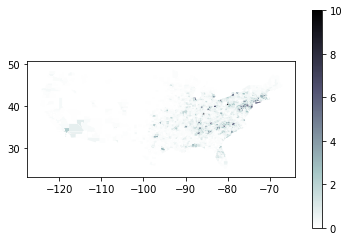

In [87]:
final_df.plot(column = 'Δmortality_O3_mean', legend = True, cmap = 'bone_r', vmin = 0, vmax = 10)

<AxesSubplot:>

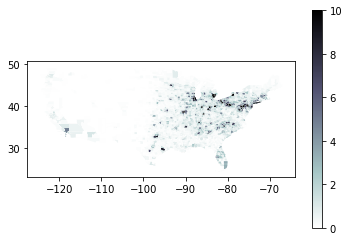

In [36]:
final_df.plot(column = 'Δmortality_PM', legend = True, cmap = 'bone_r', vmin = 0, vmax = 10)

# Analysis

In [40]:
final_df['Δmortality_O3_mean'].sum()

1218.5432548020115

In [41]:
final_df['Δmortality_PM'].sum()

4064.8108459610535

## Plot the counties with Nuclear Plants near 

In [55]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)

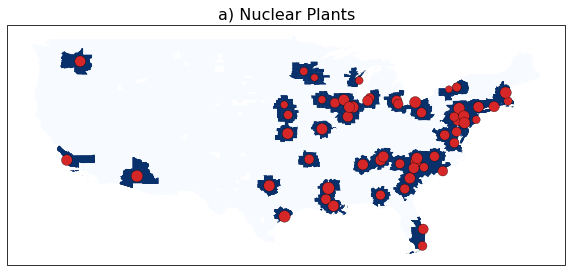

In [57]:
fig, ax = plt.subplots(figsize=[10,5], subplot_kw={'projection':ccrs.LambertConformal()})
mod_factor = 80000

###### Nuclear Plot ######

plants = ['Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']


###### Create axes ######
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) Nuclear Plants', fontsize = 16)

###### plot #######
final_df.reset_index().plot(ax = ax, column = 'nuclear_adjacent', cmap='Blues' )


#create lat and lon 
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c='C3', s = size, linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)



## Overall Difference in Exposure by Race

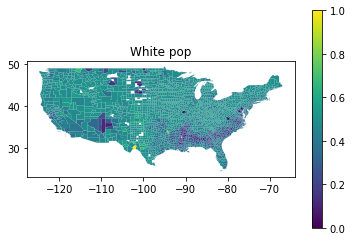

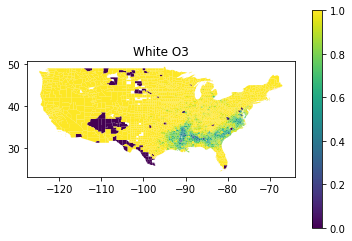

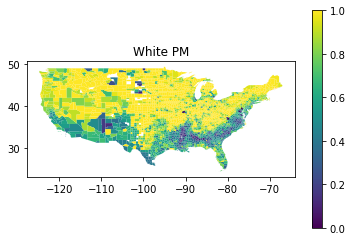

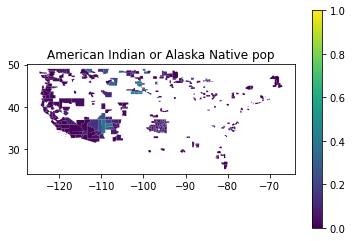

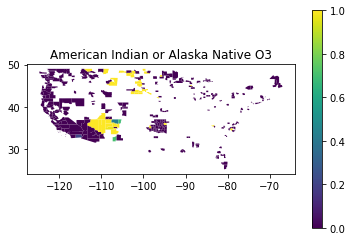

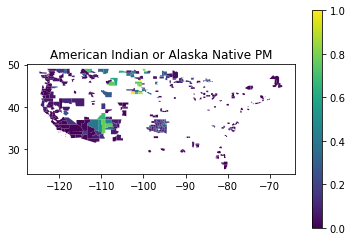

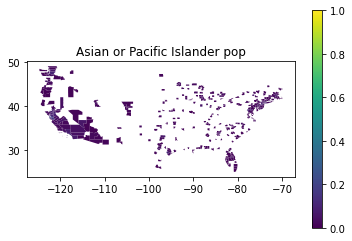

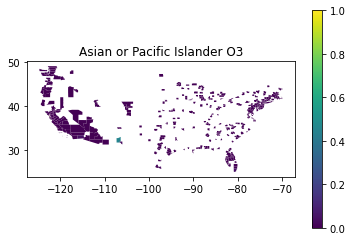

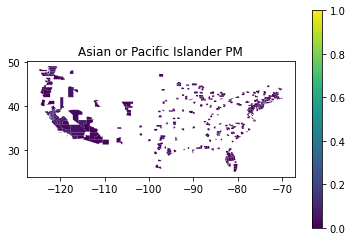

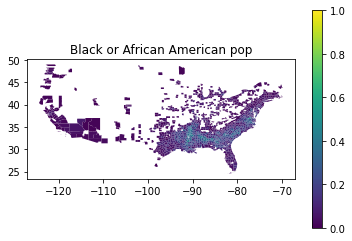

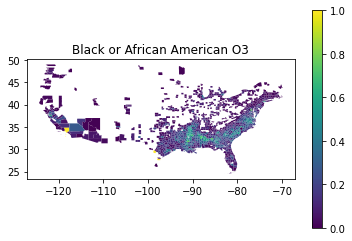

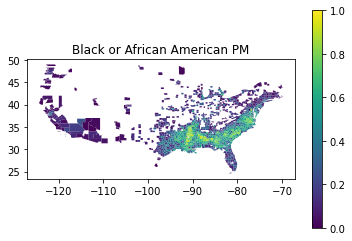

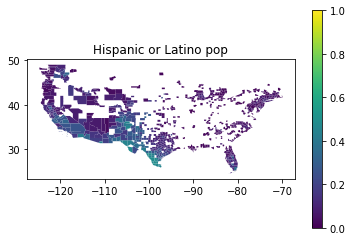

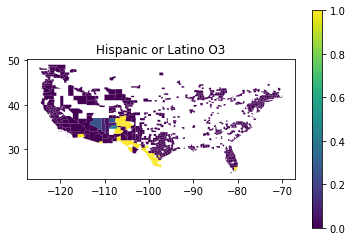

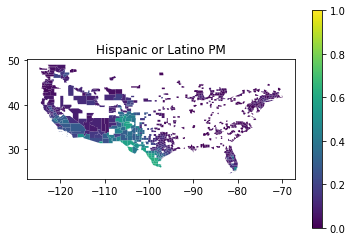

In [312]:
for idx in geo_perc_dict.keys():
    geo_perc_dict[idx].plot(column = idx, legend = True, vmin = 0, vmax = 1)
    plt.title(idx)

## Overall Difference in Mortality by Race

In [61]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re)
    print((final_df.xs(re, level = 1)['Δmortality_PM_mean'].sum()/
           final_df.xs(re, level = 1)['Population'].sum())*1e5)
    print((final_df.xs(re, level = 1)['Δmortality_O3_mean'].sum()/
           final_df.xs(re, level = 1)['Population'].sum())*1e5)

American Indian or Alaska Native
0.37931876235495526
-0.40653668495823475
Asian or Pacific Islander
0.2818580259849691
-0.11180051239966439
Black or African American
2.8775436359335775
0.32988539548879975
Hispanic or Latino
0.2853615346022944
-0.10601257525272914
White
1.0306773552604618
0.46443654863360684


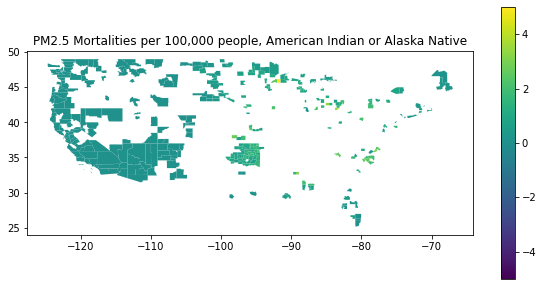

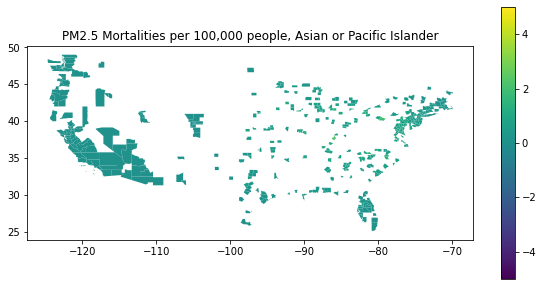

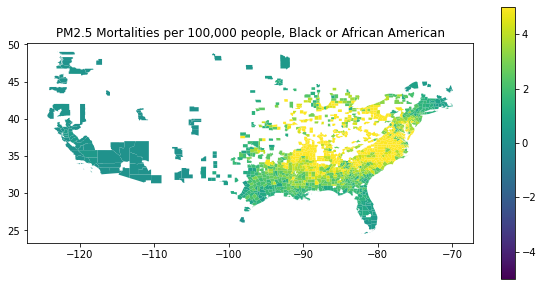

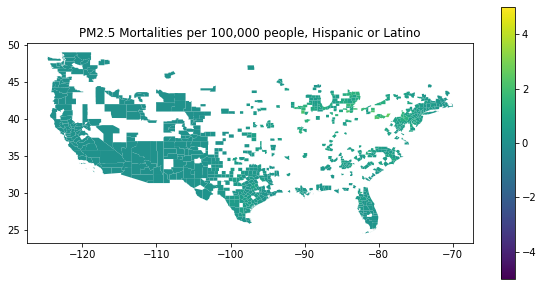

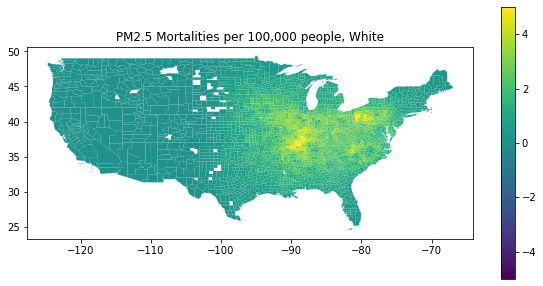

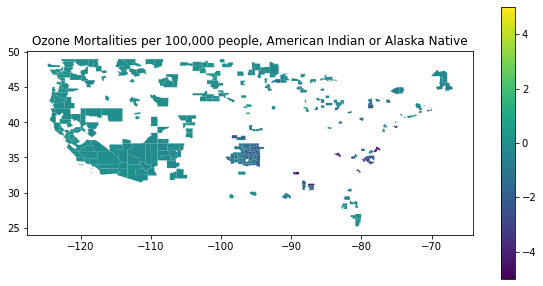

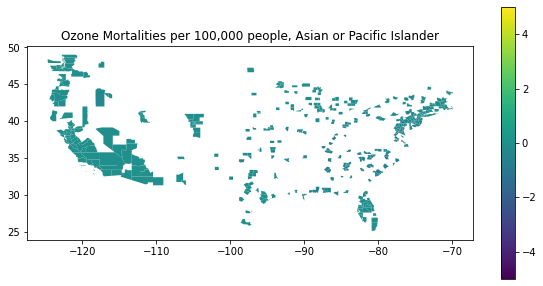

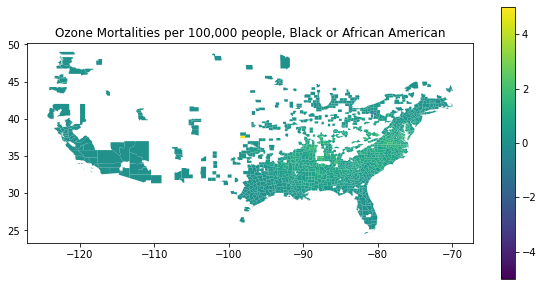

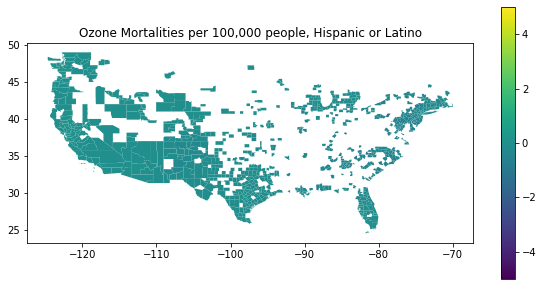

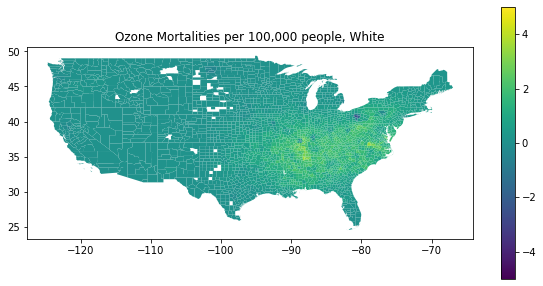

In [108]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    final_df.xs(re, level = 1).plot(column = 'PM_mortalities/population', figsize = (10,5), legend = True, vmax = 5, vmin = -5)
    
    plt.title('PM2.5 Mortalities per 100,000 people, ' + re)
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    final_df.xs(re, level = 1).plot(column = 'O3_mortalities/population', figsize = (10,5), legend = True, vmax = 5, vmin = -5)
    
    plt.title('Ozone Mortalities per 100,000 people, ' + re)


## Exposure Difference by Nuclear or Not Adjacent County

In [316]:
print(final_df.xs(True, level = 2)['PM25'].mean())
print(final_df.xs(False, level = 2)['PM25'].mean())
print(final_df.xs(True, level = 2)['O3'].mean())
print(final_df.xs(False, level = 2)['O3'].mean())

0.23675123526194067
0.16883524805575453
0.5704899515329901
0.4135888723163783


## Mortality Difference by Nuclear or Not Adjacent County

In [335]:
print((final_df.xs(True, level = 2)['Δmortality_PM'].sum()/final_df.xs(True, level = 2)['Population'].sum())*1e5)
print((final_df.xs(False, level = 2)['Δmortality_PM'].sum()/final_df.xs(False, level = 2)['Population'].sum())*1e5)
print((final_df.xs(True, level = 2)['Δmortality_O3_mean'].sum()/final_df.xs(True, level = 2)['Population'].sum())*1e5)
print((final_df.xs(False, level = 2)['Δmortality_O3_mean'].sum()/final_df.xs(False, level = 2)['Population'].sum())*1e5)

0.8108249869411983
0.5054378548987836
0.21964047339808107
0.17091309031000612


In [337]:
print((final_df.xs('Black or African American', level = 1)['Δmortality_PM'].sum()/
       final_df.xs('Black or African American', level = 1)['Population'].sum())*1e5)
print((final_df.xs('White', level = 1)['Δmortality_PM'].sum()/
       final_df.xs('White', level = 1)['Population'].sum())*1e5)
print((final_df.xs('White', level = 1)['Δmortality_PM'].sum()/
       final_df.xs('White', level = 1)['Population'].sum())*1e5)


2.8775436359335775
1.0306773552604618
1.0306773552604618


In [49]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re)
    
    print('near nuclear')
    print((final_df.xs(re, level = 1).xs(True, level = 1)['Δmortality_PM'].sum()/
           final_df.xs(re, level = 1).xs(True, level = 1)['Population'].sum())*1e5)
    print('not near nuclear')
    print((final_df.xs(re, level = 1).xs(False, level = 1)['Δmortality_PM'].sum()/
           final_df.xs(re, level = 1).xs(False, level = 1)['Population'].sum())*1e5)
    print('ratio')
    print((final_df.xs(re, level = 1).xs(True, level = 1)['Δmortality_PM'].sum()/
           final_df.xs(re, level = 1).xs(True, level = 1)['Population'].sum())/(final_df.xs(re, level = 1).xs(False, level = 1)['Δmortality_PM'].sum()/
           final_df.xs(re, level = 1).xs(False, level = 1)['Population'].sum()))

American Indian or Alaska Native
near nuclear
0.6027842154252704
not near nuclear
0.3076208195013772
ratio
1.9595039646611818
Asian or Pacific Islander
near nuclear
0.47229567534526185
not near nuclear
0.14927193045792897
ratio
3.1639952260038227
Black or African American
near nuclear
3.159554746069568
not near nuclear
2.5126240946260485
ratio
1.2574721196167633
Hispanic or Latino
near nuclear
0.4680062265213606
not near nuclear
0.1658065792289913
ratio
2.822603473864622
White
near nuclear
1.2671153904285744
not near nuclear
0.8452503786025278
ratio
1.4991006481695115


In [54]:
for re in [ 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re)
    
    print('near nuclear')
    print((final_df.xs(re, level = 1).xs(True, level = 1)['Δmortality_PM'].sum()))
    print('not near nuclear')
    print((final_df.xs(re, level = 1).xs(False, level = 1)['Δmortality_PM'].sum()))


Asian or Pacific Islander
near nuclear
35.16726114456216
not near nuclear
15.964582210019147
Black or African American
near nuclear
780.9209854727176
not near nuclear
479.92992112308025
Hispanic or Latino
near nuclear
101.23614444168683
not near nuclear
54.79301503374371
White
near nuclear
1396.881418824868
not near nuclear
1188.155199449385


In [343]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re)
    
    print('near nuclear')
    print((final_df.xs(re, level = 1).xs(True, level = 1)['Δmortality_O3_mean'].sum()/
           final_df.xs(re, level = 1).xs(True, level = 1)['Population'].sum())*1e5)
    print('not near nuclear')
    print((final_df.xs(re, level = 1).xs(False, level = 1)['Δmortality_O3_mean'].sum()/
           final_df.xs(re, level = 1).xs(False, level = 1)['Population'].sum())*1e5)


American Indian or Alaska Native
near nuclear
-0.5313903851161313
not near nuclear
-0.3664779047934013
Asian or Pacific Islander
near nuclear
-0.1753583699565741
not near nuclear
-0.06755039588204527
Black or African American
near nuclear
0.335503386355978
not near nuclear
0.3226157717873364
Hispanic or Latino
near nuclear
-0.16446462944041168
not near nuclear
-0.06775122390186195
White
near nuclear
0.5422899784074235
not near nuclear
0.4033798489569018


In [75]:
print(final_df.xs('Black or African American', level = 1).xs(True, level = 1)['Population'].sum())
print(final_df.xs('White', level = 1).xs(True, level = 1)['Population'].sum())

24716172.0
110241058.5
